# Housing price regression
From <a href="https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#4.-Missing-data">COMPREHENSIVE DATA EXPLORATION WITH PYTHON</a>


## Data Exploration

In [1]:
import numpy as np
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
TRAIN_PATH = 'datasets/train.csv'
TEST_PATH = 'datasets/test.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print('train shape:',train.shape)
print('test shape:',test.shape)

train shape: (1460, 81)
test shape: (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_id = train['Id']
test_id = test['Id']
train.drop(columns='Id', inplace=True)
test.drop(columns='Id', inplace=True)

### Analyse des 80 colonnes 
* Nom
* Type 
* Segment
* Importance (potentielle)

Objectif : en sélecionner entre 5 et 10 importantes

In [5]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

* Variance totale (SCT)
* Variance interclasse (SCE)
* Variance intraclasse
* $\eta^2_{Y|X}$ = $\frac{V_{interclasse}}{V_{totale}}$
* Si $\eta^2$ proche de 0, a priori, pas de relation entre les deux variables.
* Si $\eta^2$ proche de 1, les moyennes des classes sont très différentes d'une classe à l'autre mais qu'aun sein d'une même classe les valeurs sont très dispersées autour de la moyenne de classe. Il existe donc une très forte relation en X et Y.

In [6]:
def plot_quali_quanti(data,X,Y,distrib=True):
    """
    Analyse bivariée en affichant les boxplot categorie par categorie
    - data : pd.Dataframe
    - X : str colonne quali
    - Y : str colonne quanti
    """
    # recup chaque categ
    categories = data[X].unique()
    # regroupe par categ les valeurs de SalePrice (Y)
    groupes = [data.loc[data[X] == cat][Y] for cat in categories]

    # Propriétés graphiques 
    medianprops = {'color':"black"} # median indiquee en noir
    meanprops = {'marker':'o', 'markeredgecolor':'black', # mean indiquee en rouge
                'markerfacecolor':'firebrick'}
    plt.boxplot(groupes, labels=categories, showfliers=False, medianprops=medianprops,
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()
    
    if distrib:
        # Diagramme en secteurs
        #data[X].value_counts(normalize=True).plot(kind='pie')
        # Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
        #plt.axis('equal') 
        #plt.show() # Affiche le graphique

        # Diagramme en tuyaux d'orgues
        data[X].value_counts(normalize=True).plot(kind='bar')
        plt.show()

def eta_squared(x,y):
    """
    Calcul ETA squared, cad somme des carrés expliquée/ somme des carrés totale,
    Soit la variance de Y que X explique.
    - X : str colonne quali
    - Y : str colonne quanti
    """
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

def plot_quanti_quanti(data,X,Y):
    """
    Analyse bivariée en affichant le scatter plot des deux variables quanti
    - data : pd.Dataframe
    - X : str colonne quanti
    - Y : str colonne quanti
    """
    ax = sns.scatterplot(x=X, y=Y, data=data[[X,Y]])

def coef_determination(data,X,Y):
    """
    Calcul ETA squared, cad somme des carrés expliquée/ somme des carrés totale,
    Soit la variance de Y que X explique.
    - data : pd.Dataframe
    - X : str colonne quanti
    - Y : str colonne quanti
    """
    corr = data[[X,Y]].corr().iloc[0,1]
    # return pearson corr and R2
    return corr, corr**2

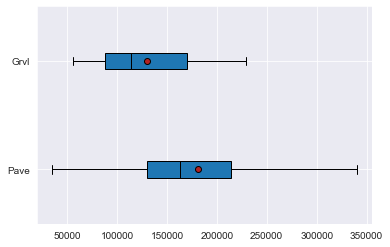

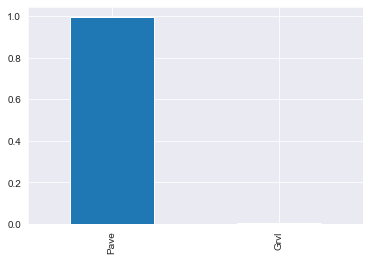

Rapport de corrélation eta2: 0.0016839151737758247


In [7]:
# analyse bivariée MSZoning et SalePrice
X = 'Street'
Y = 'SalePrice'

plot_quali_quanti(train,X,Y)
print('Rapport de corrélation eta2:',(eta_squared(train[X],train[Y])))

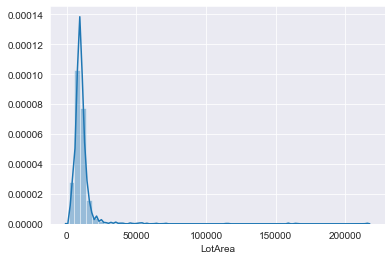

In [8]:
sns.distplot(train['LotArea']);

In [9]:
X = 'LotArea'
Y = 'SalePrice'

r_squared = coef_determination(train,X,Y)
print('Coefficient de corrélation:',r_squared[0])
print('Coefficient de détermination R2:',r_squared[1])

Coefficient de corrélation: 0.2638433538714063
Coefficient de détermination R2: 0.06961331538211211


In [10]:
from scipy.stats import spearmanr, pearsonr

corr, p_value_corr = pearsonr(train[X],train[Y])
scorr, p_value_scorr = spearmanr(train[X],train[Y])

print('Pearson : correlation=',round(corr,2), 'p-value=',round(p_value_corr,2))
print('Spearman: correlation=',round(scorr,2), 'p-value=',round(p_value_scorr,2))

Pearson : correlation= 0.26 p-value= 0.0
Spearman: correlation= 0.46 p-value= 0.0


## Feature selection
Choix colonnes top 10 à la mains

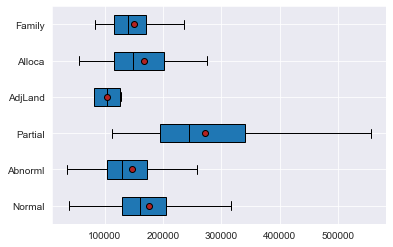

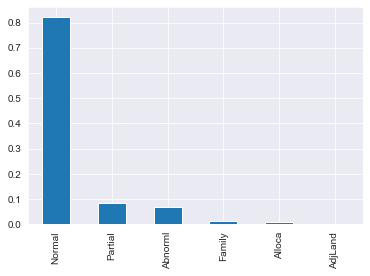

Rapport de corrélation eta2: 0.13549747687070085


In [11]:
# analyse bivariée Utilities et SalePrice
X = 'SaleCondition'
Y = 'SalePrice'

plot_quali_quanti(train,X,Y)
print('Rapport de corrélation eta2:',(eta_squared(train[X],train[Y])))

Pearson : correlation= 0.61 p-value= 0.0
Spearman: correlation= 0.6 p-value= 0.0
Coefficient de corrélation: 0.6135805515591944


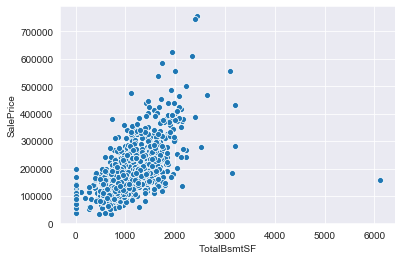

In [12]:
X = 'TotalBsmtSF'
Y = 'SalePrice'

corr, p_value_corr = pearsonr(train[X],train[Y])
scorr, p_value_scorr = spearmanr(train[X],train[Y])

print('Pearson : correlation=',round(corr,2), 'p-value=',round(p_value_corr,2))
print('Spearman: correlation=',round(scorr,2), 'p-value=',round(p_value_scorr,2))

r_squared = coef_determination(train,X,Y)
print('Coefficient de corrélation:',r_squared[0])

plot_quanti_quanti(train,X,Y)

In [13]:
cols_quali = {'MSZoning': 0.1,'Neighborhood': 0.54,'OverallQual' :0.68,'OverallCond' :0.12,'Exterior1st' :0.15,
              'ExterQual': 0.47,'Foundation': 0.25,'HeatingQC': 0.19,'FullBath': 0.3,'KitchenQual': 0.45,
              'TotRmsAbvGrd': 0.3,'Fireplaces': 0.2,'GarageCars': 0.49}

cols_quanti = {'YearBuilt': 0.58, 'YearRemodAdd': 0.5,'MasVnrArea': 0.47,'1stFlrSF': 0.6,'GrLivArea': 0.7,'GarageArea': 0.6,
              'TotalBsmtSF':0.61}

cols_uncompleted = ['Alley','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical',
                   'FireplaceQu', 'GarageType','GarageFinish','GarageCond' ]

myster = ['MasVnrArea','GarageYrBlt']

In [14]:
quali = pd.DataFrame(data=cols_quali.values(), index=cols_quali.keys(),columns=['correlation'])
quanti = pd.DataFrame(data=cols_quanti.values(), index=cols_quanti.keys(),columns=['correlation'])

In [15]:
quanti.sort_values('correlation',ascending=False)

,correlation
GrLivArea,0.70
TotalBsmtSF,0.61
1stFlrSF,0.60
GarageArea,0.60
YearBuilt,0.58
YearRemodAdd,0.50
MasVnrArea,0.47


In [16]:
quali.sort_values('correlation',ascending=False)

,correlation
OverallQual,0.68
Neighborhood,0.54
GarageCars,0.49
ExterQual,0.47
KitchenQual,0.45
FullBath,0.30
TotRmsAbvGrd,0.30
Foundation,0.25
Fireplaces,0.20
HeatingQC,0.19


## Analyse Target variable

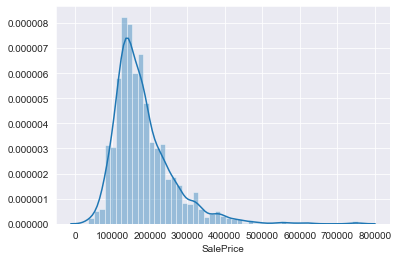

In [17]:
# target variable : 'SalePrice'
sns.distplot(train['SalePrice']);

Visiblement, une Distribution assez proche de la gaussienne, un étalement (skewness) à droite et un pic assez prononcé.

In [18]:
# Analyse tendance centrale : mode, mediane et mean
mode = train['SalePrice'].mode().values[0]
mean = train['SalePrice'].mean()
median = train['SalePrice'].median()

print("mode :",round(mode,2))
print("median :",round(median,2))
print("moyenne empirique:",round(mean,2))

# Analyse dispersion : variance et ecart-type
variance = train['SalePrice'].var()
std = train['SalePrice'].std()

print("ecart-type :",round(std,2))
print("variance empirique:",round(variance,2))

# Analyse de forme : asymétrie (skewness) et applatissement (kurtosis)
gamma = train['SalePrice'].skew()
kurtosis = train['SalePrice'].kurtosis()

print("Skewness empirique:",round(gamma,2))
print("Kurtosis empirique:",round(kurtosis,2))

mode : 140000
median : 163000.0
moyenne empirique: 180921.2
ecart-type : 79442.5
variance empirique: 6311111264.3
Skewness empirique: 1.88
Kurtosis empirique: 6.54


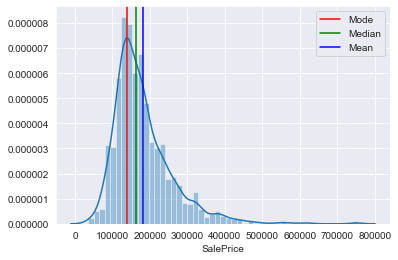

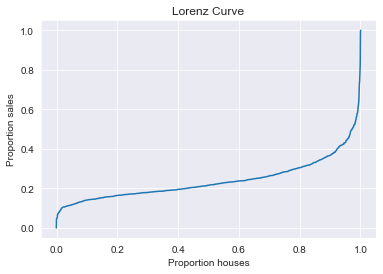

In [19]:
from matplotlib import lines
sns.distplot(train['SalePrice'])
plt.axvline(mode, color='r', linewidth=1.5)
plt.axvline(mean, color='b',linewidth=1.5)
plt.axvline(median, color='g', linewidth=1.5)
plt.legend(handles=[lines.Line2D([], [], color='red',markersize=15, label="Mode"),
                    lines.Line2D([], [], color='green',markersize=15, label="Median"),
                    lines.Line2D([], [], color='blue',markersize=15, label="Mean")])
plt.show();

# Analyse concentration : courbe de Lorenz
sales = train['SalePrice']
n = len(sales)
sales = sales.sort_values().values
sales = sales/sales[-1]

lorenz = np.append([0],sales)
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz)
plt.title('Lorenz Curve')
plt.xlabel('Proportion houses')
plt.ylabel('Proportion sales')
plt.show()

Mode < Median < Mean => $\gamma>0$

## Analyse quantitative bivariée

In [20]:
# cols des variables quantitatives
cols = quanti.index.values
cols = np.append(cols,'SalePrice')

# dataset des variables quantitatives
train_quanti = train[cols].copy()
train_quanti.head()

,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,GrLivArea,GarageArea,TotalBsmtSF,SalePrice
0,2003,2003,196.0,856,1710,548,856,208500
1,1976,1976,0.0,1262,1262,460,1262,181500
2,2001,2002,162.0,920,1786,608,920,223500
3,1915,1970,0.0,961,1717,642,756,140000
4,2000,2000,350.0,1145,2198,836,1145,250000


In [21]:
train_quanti.describe()

,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,GrLivArea,GarageArea,TotalBsmtSF,SalePrice
count,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1971.267808,1984.865753,103.685262,1162.626712,1515.463699,472.980137,1057.429452,180921.195890
std,30.202904,20.645407,181.066207,386.587738,525.480383,213.804841,438.705324,79442.502883
min,1872.000000,1950.000000,0.000000,334.000000,334.000000,0.000000,0.000000,34900.000000
25%,1954.000000,1967.000000,0.000000,882.000000,1129.500000,334.500000,795.750000,129975.000000
50%,1973.000000,1994.000000,0.000000,1087.000000,1464.000000,480.000000,991.500000,163000.000000
75%,2000.000000,2004.000000,166.000000,1391.250000,1776.750000,576.000000,1298.250000,214000.000000
max,2010.000000,2010.000000,1600.000000,4692.000000,5642.000000,1418.000000,6110.000000,755000.000000


In [22]:
train_quanti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
YearBuilt       1460 non-null int64
YearRemodAdd    1460 non-null int64
MasVnrArea      1452 non-null float64
1stFlrSF        1460 non-null int64
GrLivArea       1460 non-null int64
GarageArea      1460 non-null int64
TotalBsmtSF     1460 non-null int64
SalePrice       1460 non-null int64
dtypes: float64(1), int64(7)
memory usage: 91.3 KB


(1452, 8)


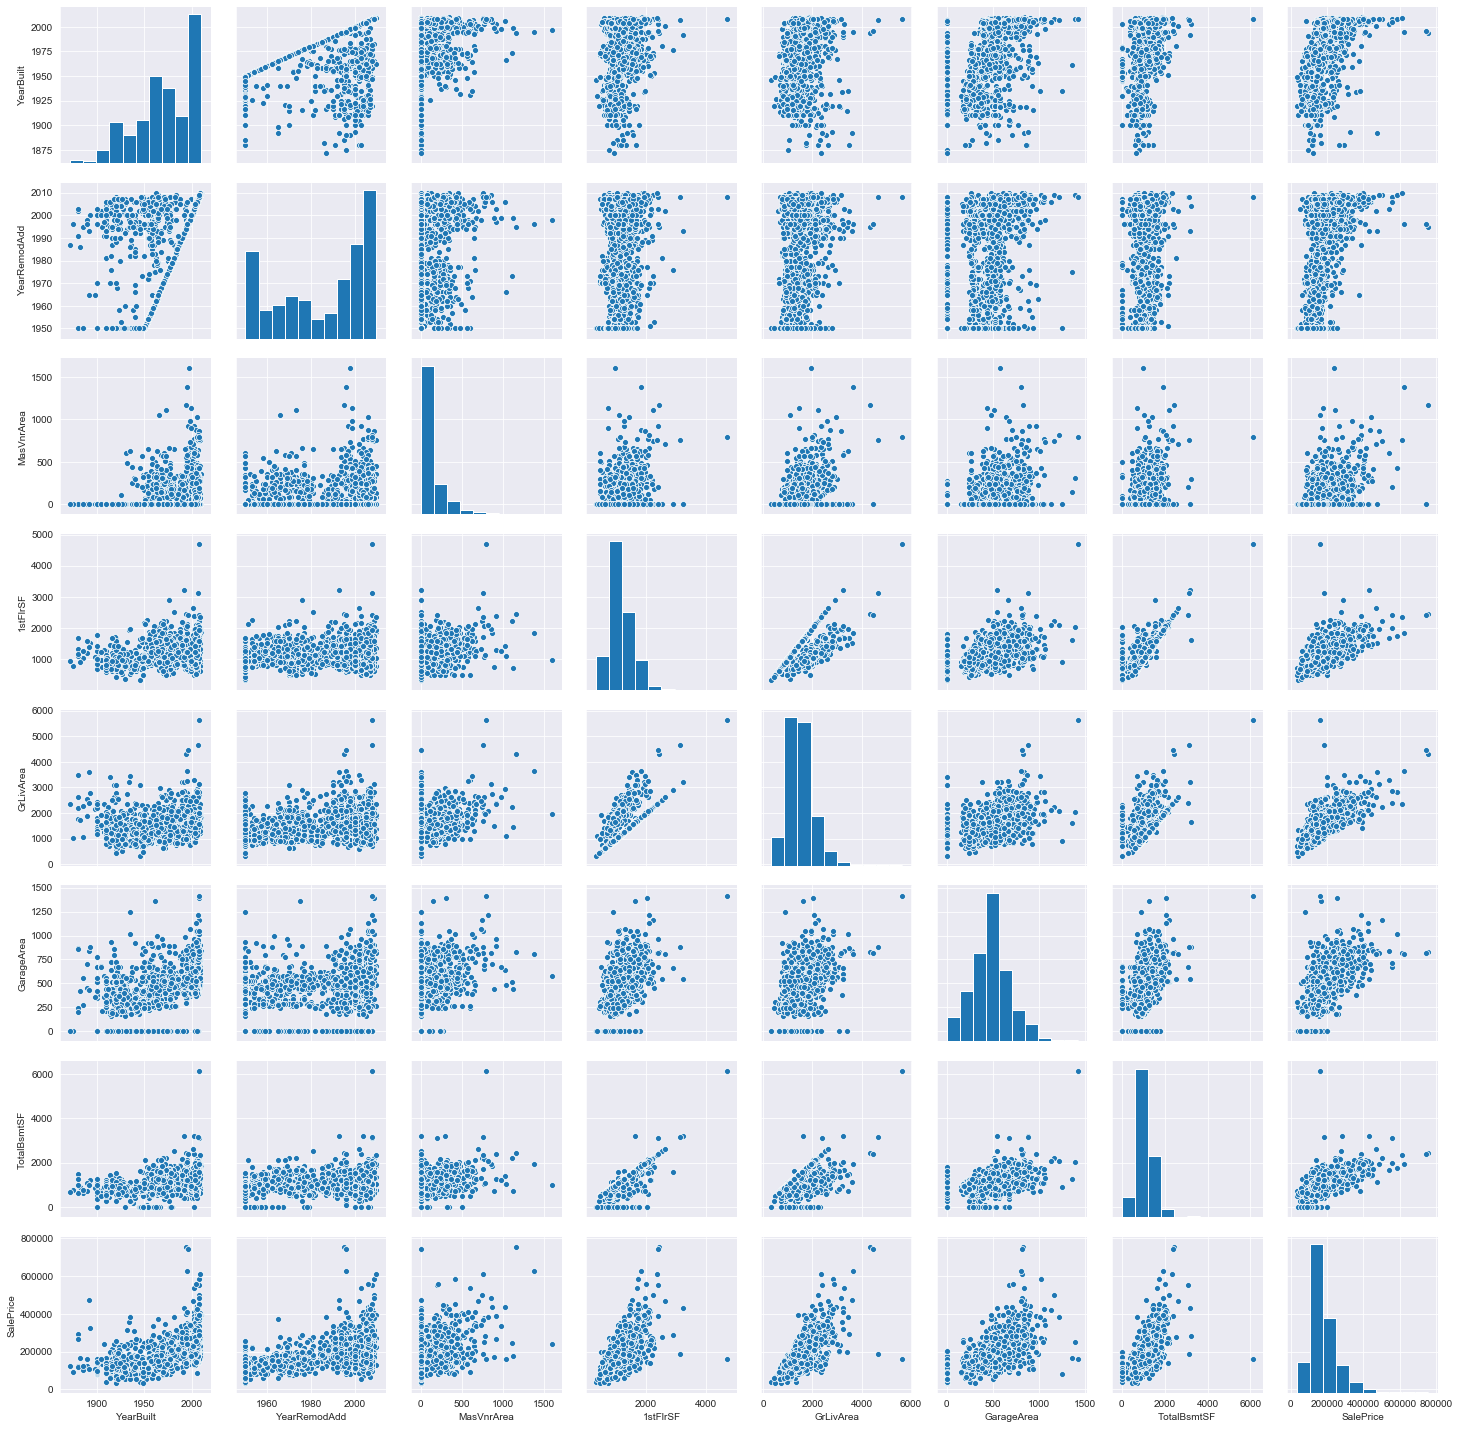

In [23]:
train_quanti.dropna(inplace=True)
print(train_quanti.shape)
sns.pairplot(train_quanti);

Plusieurs conclusions : 
* GrLivArea et 1stFlrSF semblent très corrélés linéairement avec SalePrice. De même pour GarageArea même si quelques instances sont nulles (<5%). 
* Forte correlation lineaire entre GrLivArea et 1stFlrSF. Logique puisque dans le cas de maisons sur 1 etage, les valeurs sont identiques (d'où la droite tracée clairement). 
* TotalBsmtSF est aussi corrélé avec SalePrice mais aussi avec GrLivArea. (logique ici aussi vu qu'il s'agit de la surface du sous-sol). La relation est presque exponetielle, plus que lineaire
* On remarque la présence de certains outliers extremes, qui peuvent biaiser l'apprentissage suivant l'algo.

## Analyse qualitative - quantitative

In [24]:
quanti = ['GrLivArea', '1stFlrSF','GarageArea','TotalBsmtSF', 'YearBuilt']

MSZoning


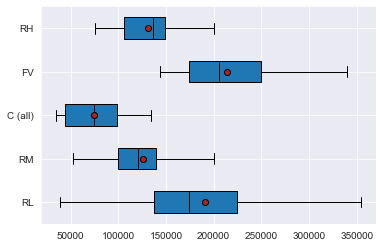

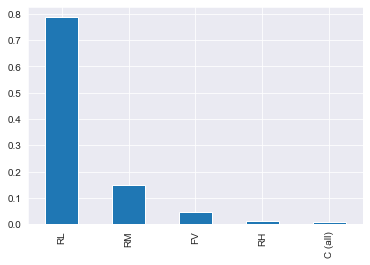

Rapport de corrélation eta2: 0.10755968344624955
Neighborhood


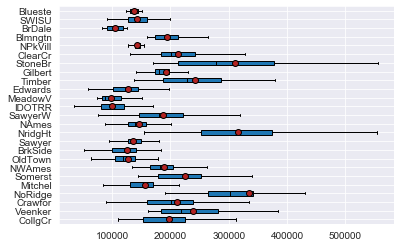

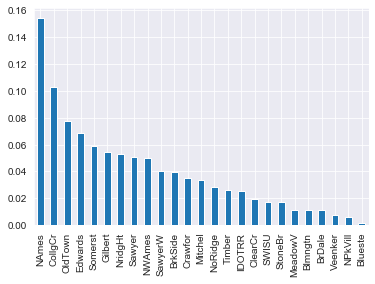

Rapport de corrélation eta2: 0.5455749908095627
OverallQual


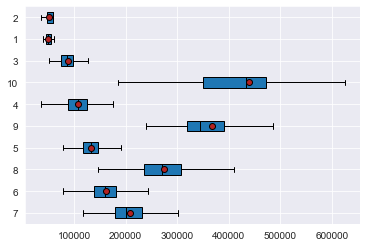

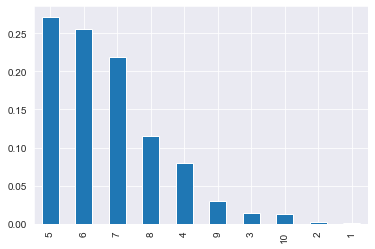

Rapport de corrélation eta2: 0.6841812868534436
OverallCond


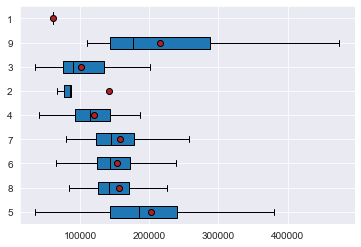

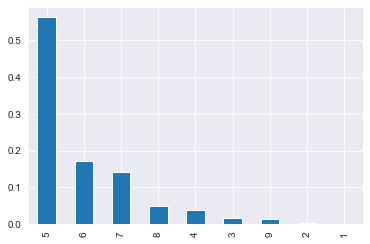

Rapport de corrélation eta2: 0.12539011556327637
Exterior1st


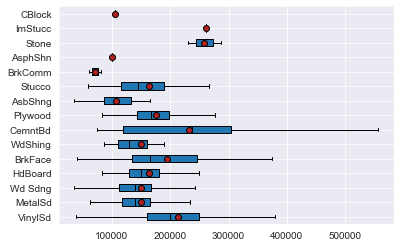

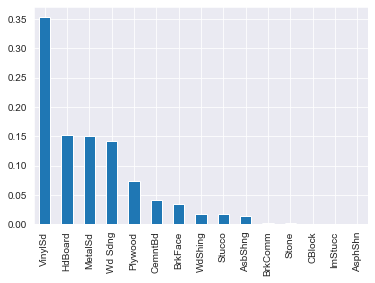

Rapport de corrélation eta2: 0.1527731231420937
ExterQual


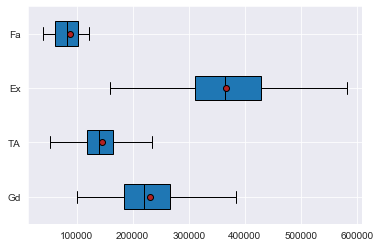

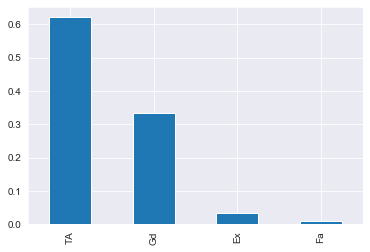

Rapport de corrélation eta2: 0.4773877777270063
Foundation


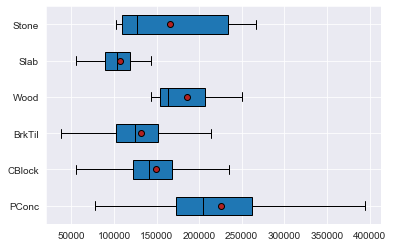

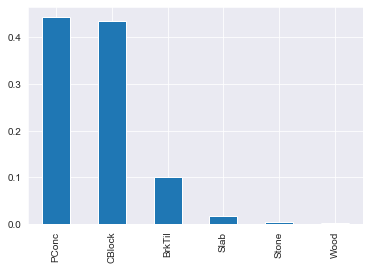

Rapport de corrélation eta2: 0.2563684015304178
HeatingQC


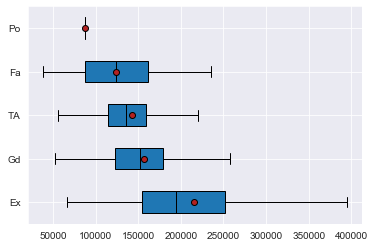

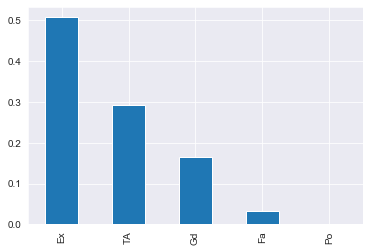

Rapport de corrélation eta2: 0.195500485840093
FullBath


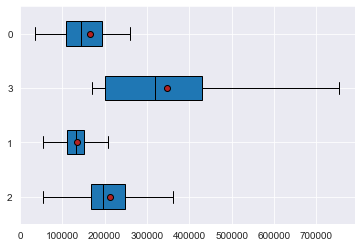

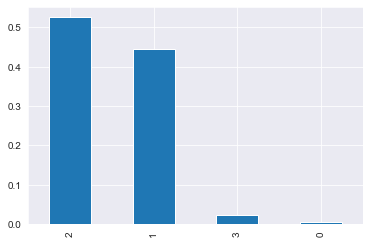

Rapport de corrélation eta2: 0.3364327187041485
KitchenQual


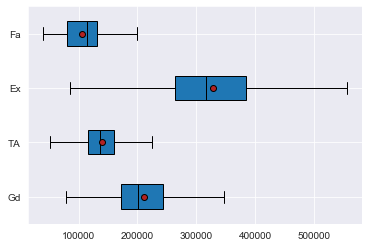

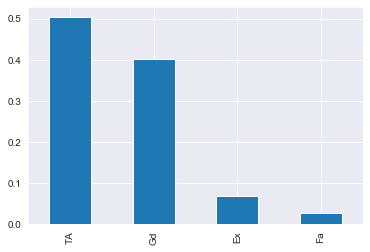

Rapport de corrélation eta2: 0.456598624444538
TotRmsAbvGrd


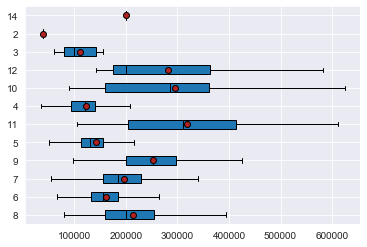

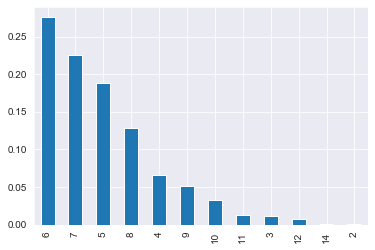

Rapport de corrélation eta2: 0.2990631428538028
Fireplaces


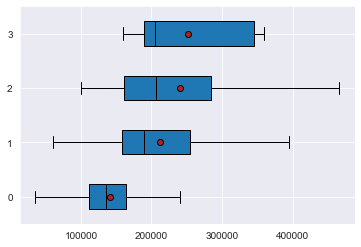

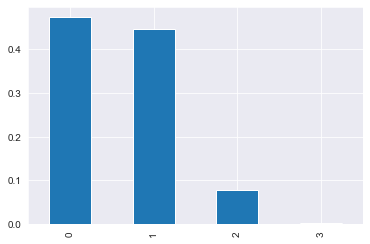

Rapport de corrélation eta2: 0.23215803471656812
GarageCars


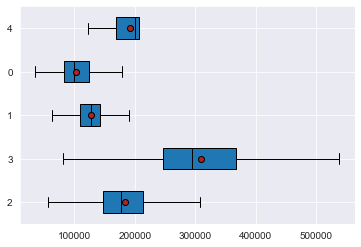

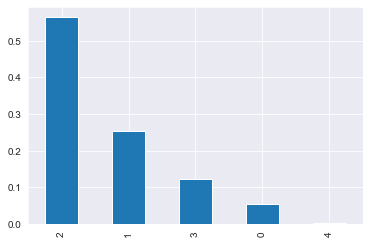

Rapport de corrélation eta2: 0.49122848978214295


In [25]:
Y = 'SalePrice'

for X in quali.index.values:
    print(X)
    plot_quali_quanti(train,X,Y)
    print('Rapport de corrélation eta2:',(eta_squared(train[X],train[Y])))

In [26]:
quali = ['OverallQual','GarageCars','ExterQual','KitchenQual']

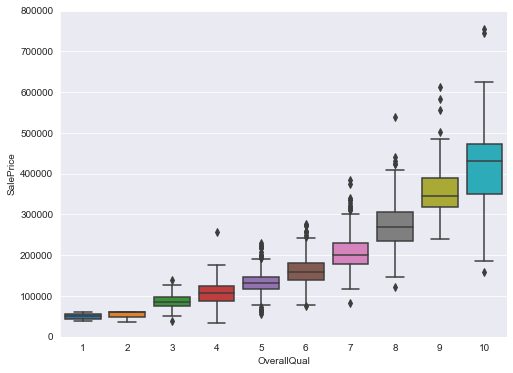

In [27]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

## Analyse plus fine: 
* CorrelationS

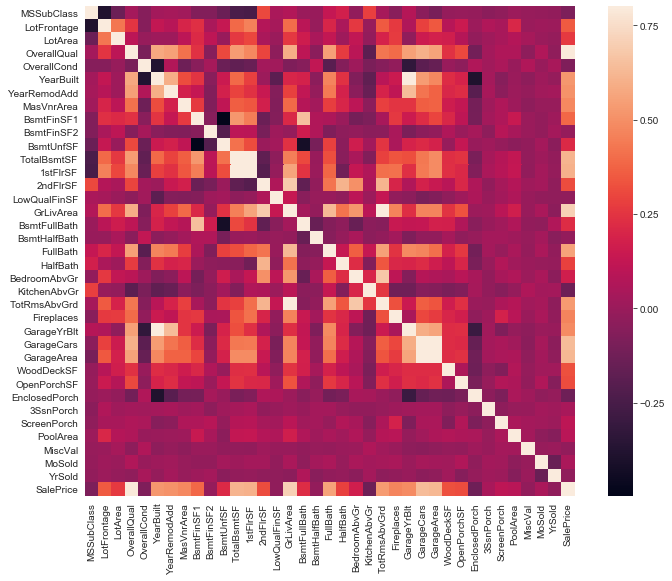

In [28]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

* GarageCars & GarageAreas très corrélés. 
* TotalBsmtSF & 1stFlrSF très corrélés.

Focus sur les k plus corrélés en absolue : 

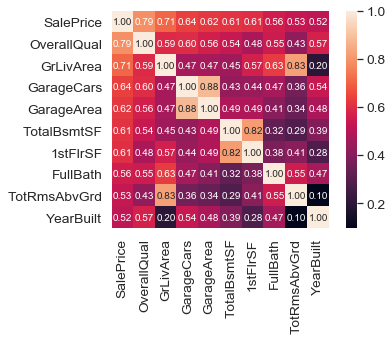

In [29]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

* GrLivArea & TotRmsAbvGrd very correlated.
* GarageCars & GarageAreas très corrélés. 
* TotalBsmtSF & 1stFlrSF très corrélés.

# Missing data

In [30]:
missings = train.isnull().sum()
cols_missing = missings.loc[missings>0]
100*cols_missing.sort_values(ascending=False)/len(train)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

* PoolQC,MiscFeature,Alley,Fence,FireplaceQu et LotFrontage ont entre 17% et 99% de valeurs manquantes. Une solution consiste à  supprimer radicalement ces variables.
* Les variables GaragesX possedent toute $\sim$5.54% de valeurs manquantes, faisant certainement toute reference aux mêmes individus. Etant donnée (d'apres notre précédente analyse) que la varaible GarageCars était la + importante. De même pour BsmtX
* Pour les autres variables, on peut envisager de 
    * 1) les compléter (médiane/moyenne/regression linéaire) 
    * 2) supprimer les lignes avec valeurs manquantes.

On supprimes également MasVnrArea et MasVnrType, très proche de YearBuilt et OverallQual. Il reste donc Electrical qui ne possède que tres peu de valeurs manquantes. On supprime les lignes concernées.

In [31]:
train.drop(columns=cols_missing.loc[cols_missing>1].index, inplace=True)
train.dropna(inplace=True)

## Outliers

In [32]:
#Univariate analysis : 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

sales_scaled = scaler.fit_transform(train['SalePrice'][:,np.newaxis]) # StandardScaler needs 2D array and not a Series ! 

In [33]:
sales_scaled = sales_scaled.flatten()
sorted_idx = sales_scaled.argsort()

In [34]:
low_range = sales_scaled[sorted_idx[:10]]
high_range = sales_scaled[sorted_idx[-10:]]

print(low_range,high_range)

[-1.83820775 -1.83303414 -1.80044422 -1.78282123 -1.77400974 -1.62295562
 -1.6166617  -1.58519209 -1.58519209 -1.57269236] [3.82758058 4.0395221  4.49473628 4.70872962 4.728631   5.06034585
 5.42191907 5.58987866 7.10041987 7.22629831]


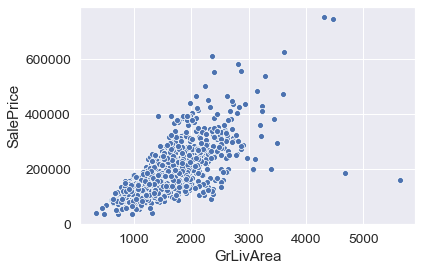

In [35]:
X ="GrLivArea"
Y = 'SalePrice'

plot_quanti_quanti(train,X,Y)

Deux valeurs semblent bien être des outliers. Les deux autres tres eloignées semblent suivre la tendance générale et donc on les garde.

In [36]:
# isoler ces deux valeurs.
train.sort_values(by='GrLivArea',ascending = False)[:2]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,...,0,0,0,480,0,1,2008,New,Partial,160000
523,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,0,10,2007,New,Partial,184750


In [37]:
train.drop(523,inplace=True)
train.drop(1298,inplace=True)

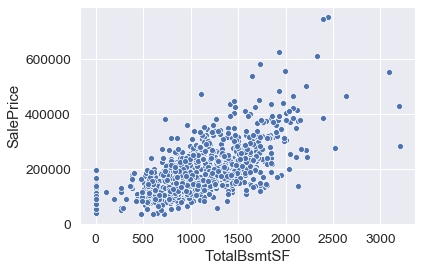

In [38]:
X ="TotalBsmtSF"
Y = 'SalePrice'

plot_quanti_quanti(train,X,Y)

Les valeurs a zero pourraient etre eliminées mais elles ne representent pas un probleme normalement.

## Assumption about data
* Normality
* Homoscedasticity 
* Linearity
* Absence of correlated errors

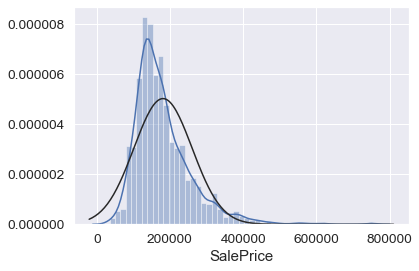

In [39]:
from scipy.stats import norm
sns.distplot(train[Y],fit=norm);

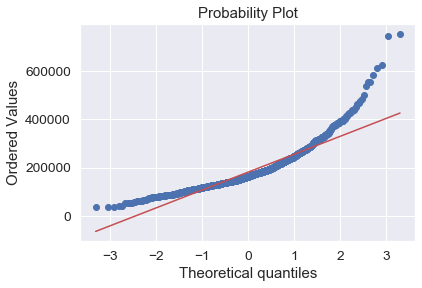

In [40]:
from scipy.stats import probplot
fig = plt.figure()
res = probplot(train[Y],plot=plt)

Notre variable est donc trop etalée sur la droite

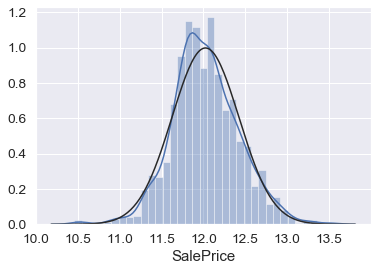

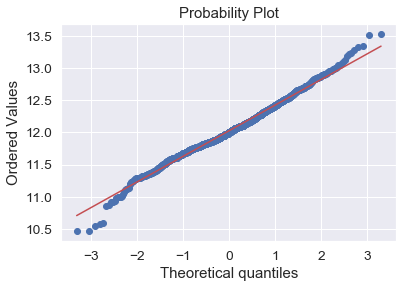

In [41]:
train[Y] = np.log(train[Y])

sns.distplot(train[Y],fit=norm);

fig = plt.figure()
res = probplot(train[Y],plot=plt)

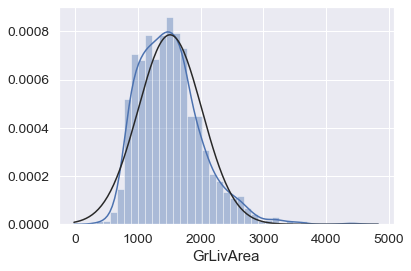

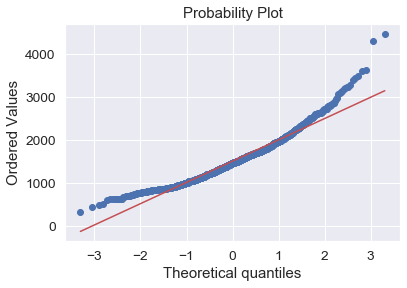

In [42]:
X = 'GrLivArea'
sns.distplot(train[X],fit=norm);

fig = plt.figure()
res = probplot(train[X],plot=plt)

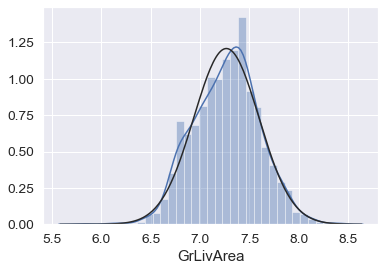

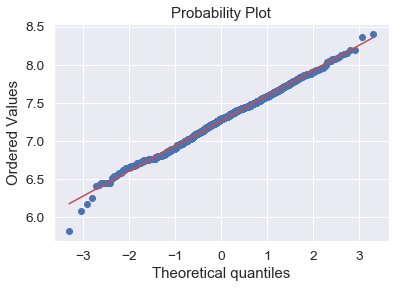

In [43]:
train[X] = np.log(train[X])
sns.distplot(train[X],fit=norm);

fig = plt.figure()
res = probplot(train[X],plot=plt)

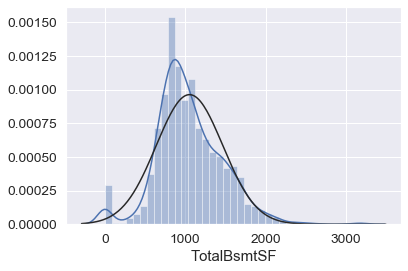

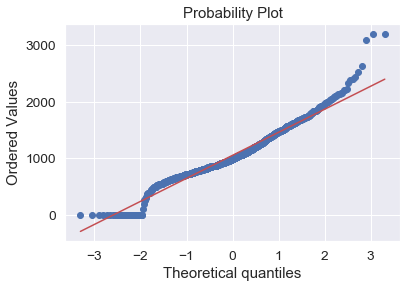

In [44]:
X ="TotalBsmtSF"

sns.distplot(train[X],fit=norm);

fig = plt.figure()
res = probplot(train[X],plot=plt)

les valeurs à 0 empechent l'utilisation du Log

In [45]:
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

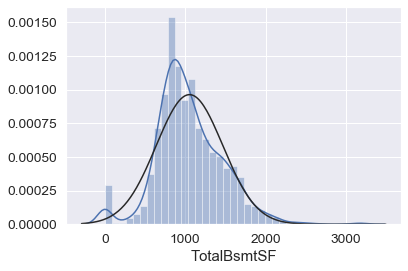

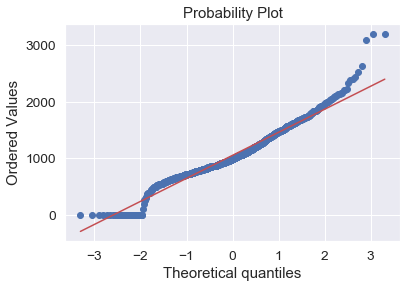

In [46]:
#transform data
#train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

sns.distplot(train[X],fit=norm);

fig = plt.figure()
res = probplot(train[X],plot=plt)

Check homoscedasticity : 

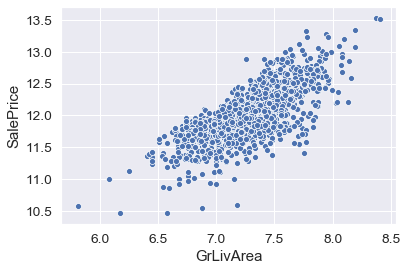

In [47]:
X ="GrLivArea"
Y = 'SalePrice'

plot_quanti_quanti(train,X,Y)

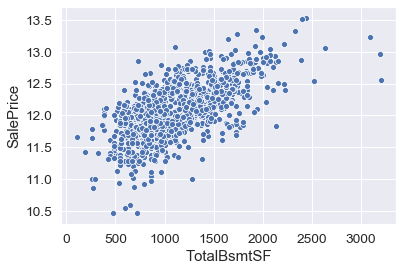

In [49]:
X ="TotalBsmtSF"
Y = 'SalePrice'

plot_quanti_quanti(train.loc[train[X]>0],X,Y) # uniquement quand il y a un sous-sol

In [50]:
a = pd.get_dummies(train)
a.shape

(1457, 221)